In [8]:
import tripyview.sub_notebookheader as nb_setup
# which_matplotlib = 'inline' (default), 
#                    'notebook'(jupyter notebook), 
#                    'widget'(jupyterlab)
nb_setup.init_notebook(which_matplotlib="inline")
# centralized autoimport of: 
# import os
# import warnings
# import time as clock
# import numpy as np
# import xarray as xr
# import shapefile as shp
# import tripyview as tpv
# client, use_existing_client = None, "tcp://0.0.0.0:0000"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### INFO:
To compute especially on large unstructured grids #vertices>1M, you need to run this notebook in parallel (do_parallel=True) on several workers (parallel_nprc...is the number of dask worker that can be allocated, parallel_tmem...is the maximum available RAM that will be distributed between the dask workers). Therefor allocate a full !!! COMPUTE NODE !!! (admins might not be happy if you do this in parallel on a login node) of a HPC of your choice with as much memory (RAM) as you can get to run this notebook!

In [9]:
# parameters
#___Dask Client Parameters____________________________________________________________
do_papermill      = False
do_parallel       = True
parallel_nprc     = 64   # number of total processes
parallel_nthread  = 2    # number of threads per worker --> number worker = parallel_nprc/parallel_nthread
parallel_tmem     = 256  # max. available RAM

#___Mesh Path & Save Path_____________________________________________________________
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path         = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
# mesh_path         = '/work/ba1264/a270210/model/input/fesom2/dart/'

save_path         = None #'~/figures/test_papermill/'
save_fname        = None # filename from papermill come in through save_fname
tripyrun_name     = None # papermill workflow name of notebook 
tripyrun_analysis = None # papermill diagnostic driver
tripyrun_spath_nb = None # papermill path to processed notebooks
tripyrun_spath_fig= None # papermill path to processed figures

#___Data Path & Input Names___________________________________________________________
input_paths   = list()
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')
# input_paths.append('/work/ab0995/a270210/runtime/awicm3-v3.1_refactoring/TCO319L137-DART/hist1950d/outdata/fesom/')

input_names   = list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')
# input_names.append('Tido Test')

# n_cycl: which spinupcycle should be plottet if do_allcycl all spinupcycles from [1...n_cycle] are plottet, if None path is directly used
n_cycl    = None
do_allcycl= False
vname     = 'temp'
year      = [1958, 2019]
mon       = None
day       = None
record    = None 
box       = None
depth     = None

#___Define Reference Data, Year, Mon ...______________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None # '/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/'
ref_name  = None # 'TKE'
ref_year  = None #[1979, 2019]
ref_mon   = None
ref_day   = None
ref_record= None

#___Define Boxregion via shape file for index compuation______________________________
box_region = list()
box_region.append('global')
box_region.append('ocean_basins/Arctic_Basin.shp')
# box_region.append('ocean_basins/Eurasian_Basin.shp')
# box_region.append('mpas_region/Canada_Basin.shp')
# box_region.append('mpas_region/North_Atlantic_Ocean.shp')
# box_region.append('mpas_region/Greenland_Sea.shp')
# box_region.append('mpas_region/Irminger_Sea.shp')
# box_region.append('mpas_region/Norwegian_Sea.shp')
# box_region.append('mpas_region/Labrador_Sea.shp')
# box_region.append('mpas_region/North_Pacific_Ocean.shp')
# box_region.append('mpas_region/South_Pacific_Ocean.shp')
# box_region.append('mpas_region/Southern_Ocean.shp')
# box_region.append('mpas_region/Western_Weddell_Sea.shp')

#___Define Climatology________________________________________________________________
which_clim= 'phc3'
clim_path = '/albedo/work/projects/p_fesom/FROM-OLLIE/FESOM2/hydrography/phc3.0/phc3.0_annual.nc'
# clim_path = '/pool/data/AWICM/FESOM2/INITIAL/phc3.0/phc3.0_annual.nc'

#___Define Colormap Parameters________________________________________________________
# papermill doesnt like multi variable alignment in a single line
cstr      = 'blue2red'
cnum      = 15
cref      = None
crange    = None
cmin      = None
cmax      = None
cfac      = None
climit    = None
chist     = True
ctresh    = 0.995

ref_cstr  = 'wbgyr'
ref_cnum  = 15
ref_cref  = None
ref_crange= None
ref_cmin  = None
ref_cmax  = None
ref_cfac  = None
ref_climit= None
ref_chist = True
ref_ctresh= 0.995

#___Define Plot Parameters____________________________________________________________
ncol              = 2      # number of pannel columns in figure
nrow              = None
box               = [-180, 180, -90, 90]
do_plt            = 'tcf'  # plot pcolor (tpc) or contourf (tcf)
plt_contb         = True   # background contour line (thin)
plt_contf         = False  # contour line of main colorbar steps 
plt_contr         = False  # contour line of reference value 
plt_contl         = False  # label contourline of main colorbar steps 
do_rescale        = None   # rescale data: None, 'log10', 'slog10', np.array(...)
do_lsm            ='fesom' # 'fesom', 'bluemarble', 'etopo', 'stock'
do_mesh           = False, 
mesh_opt          = dict({'color':'k', 'linewidth':0.10})
do_enum           = False  # do enumeration of panels
do_reffig         = True   # plot reference fig when doing anomalies 
do_clim           = False   # plot climatolgy values when doing absoluts
ax_title          = None
cb_label          = None
save_dpi          = 300
save_fmt          = ['png']

In [10]:
# start parallel dask client if do_parallel=True
client = tpv.shortcut_setup_daskclient(client, 
                                       use_existing_client, 
                                       do_parallel, 
                                       parallel_nprc, 
                                       parallel_tmem,
                                       threads_per_worker=parallel_nthread)

In [11]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', do_info=True)

#______________________________________________________________________________________________________
# create input_path spinupcycle structure
input_paths, input_names, ref_path, ref_name = tpv.shortcut_setup_pathwithspinupcycles(input_paths, input_names, ref_path, ref_name, n_cycl, do_allcycl)
         
#______________________________________________________________________________________________________        
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
ref_cinfo=None
if (ref_path != None): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record
    cinfo['cref']=0.0 
    ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)
    
#______________________________________________________________________________________________________    
# concatenate ref_path and input_path together if is not None,  concatenate list = list1+list2
input_paths, input_names = tpv.shortcut_setup_concatinputrefpath(input_paths, input_names, ref_path, ref_name)

#______________________________________________________________________________________________________
# define index regions --> reading shape files
box = tpv.shortcut_setup_boxregion(box_region)

#______________________________________________________________________________________________________
# use number of worker dependent chunk size for nodes and elements
chunks = dict({'time' : 12    , 
               'elem' : mesh.n2dn, #'auto', 
               'nod2' : mesh.n2dn, #'auto', 
               'nz1'  : 48, #np.int32((mesh.nlev)*0.5), 
               'nz'   : 48, #np.int32((mesh.nlev)*0.5), 
               'edg_n': 'auto'}) 

if client is not None:
    # set size limit of hoizontal chunks so that size of the total chunks covers 10% of worker memory
    mem_thresh     = 0.15
    worker_info    = client.run_on_scheduler(lambda dask_scheduler: {worker: ws.memory_limit for worker, ws in dask_scheduler.workers.items()})
    mem_limit_byte = next(iter(worker_info.items()))[1]
    print(' --> worker memory      : {:04.2f}Mb'.format(mem_limit_byte/1024**2))
    print(' --> limit chunksize to : {:04.2f}Mb'.format(mem_limit_byte/1024**2*mem_thresh))
    chunk_size = mem_limit_byte * mem_thresh/4 
    if   chunks['time'] != 'auto': chunk_size = chunk_size/chunks['time']
    if   chunks['nz']   != 'auto': chunk_size = chunk_size/chunks['nz']
    elif chunks['nz1']  != 'auto': chunk_size = chunk_size/chunks['nz1']
    chunks['elem']  = np.minimum(mesh.n2de, np.int32(np.ceil(chunk_size)))
    chunks['nod2']  = np.minimum(mesh.n2dn, np.int32(np.ceil(chunk_size)))
    print(' --> set elem/nod2 chunk size to {:2.2f}% of worker mem.: {:d}'.format(100*mem_thresh, chunks['elem']))
    
print(chunks)    

 > found *.jlib file: /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.jlib file: tripyview_mesh_core2_srt_dep@node_focus0.jlib
 > comp. e_resol from triangle height
 > comp n_resol from 2*sqrt(n_area/pi)
___FESOM2 MESH INFO________________________
 > path            = /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, True
 > do narea,nresol = True, True
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________
global
/albedo/home/pscholz/tripyview/tripyview ocean_basins/Arctic_Basin.shp
{'time': 12, 'elem': 126858, 'nod2': 126858, 'nz1': 48, 'nz': 48, 'edg_n': 'auto'}


In [15]:
t0 = clock.time()
# clean up garabage on workers before the party starts!
if client is not None: client.run(gc.collect)

data_list     = list()
year_list     = list(range(year[0], year[1]+1))
chnk_size     = 5 # -> you can use larger chunks here if you have enough memory
chnk_yrs_list = year_list[::chnk_size]
for ii, (datapath, descript) in enumerate(zip(input_paths, input_names)):
    print(datapath, descript)
    print(' > year:', end='')
    # compute dmoc time series in chunk of year, to prevent matrices from becoming to big and you run out of memory !!!
    # you can play with chnk_size for the case you run out of memory 
    for nchnk, year_s in enumerate(chnk_yrs_list): 
        ts = clock.time()
        year_chnk = [ year_s, np.min([year_s+chnk_size-1,year[1]]) ]  
        print(*np.arange(year_chnk[0],year_chnk[1]+1), sep='|',end='')
        #__________________________________________________________________________________________________
        moni = mon
        if (ii==0) and (ref_path != None): moni = ref_mon

        #__________________________________________________________________________
        input_dict = dict({'year':year_chnk, 'mon':moni, 'day':None, 'record':None, 'depth':None, 
                           'do_tarithm':'None', 'do_zarithm':'None', 
                           'descript':descript, 'do_info':False, 'do_nan':True, 
                           'do_load':False, 'do_persist':False, 'chunks':chunks, 'do_parallel':do_parallel})
        
        #__________________________________________________________________________________________________
        # load fesom2 data
        if  vname=='Kv*N2':
            data  = tpv.load_data_fesom2(mesh, datapath, vname='Kv', **input_dict)
            data2 = tpv.load_data_fesom2(mesh, datapath, vname='N2', **input_dict)
            data['Kv'].data = data['Kv'].data * data2['N2'].data
            data  = data.rename(dict({'Kv':'Kv*N2'}))
            data['Kv*N2'].attrs['units'], data['Kv*N2'].attrs['description'], data['Kv*N2'].attrs['long_name'] = 'm^2/s^3', 'Kv * N^2', 'Kv * N^2'
            del(data2)
        else: 
            data  = tpv.load_data_fesom2(mesh, datapath, vname=vname, **input_dict)
         
        # check if data where loaded
        if data is None: 
            print(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
            continue
       
        #_________________________________________________________________________________________________
        # create hovmoeller from chunked data piece
        data_hovm_chnk = tpv.load_index_fesom2(mesh, data, box, do_harithm='wmean', client=client, do_checkbasin=False)
        del(data)
        
        #__________________________________________________________________________________________________
        # concatenate time chunks together
        if nchnk==0: data_hovm = data_hovm_chnk
        else       : 
            for ii in range(0,len(box)):
                data_hovm[ii] = xr.concat([data_hovm[ii], data_hovm_chnk[ii]], dim='time')
        del(data_hovm_chnk)
        print(' --> elasped time: {:3.2f} min.'.format( (clock.time()-ts)/60  ), end='\n        ')
        if client is not None: client.run(gc.collect) 
        
    #______________________________________________________________________________________________________
    print('')
    for ii, data_ii in enumerate(data_hovm):
        print(' --> data_hovm[{:s}] uses {:3.2f} Mb:'.format(data_hovm[ii][list(data_hovm[ii].keys())[0]].attrs['boxname'], data_hovm[ii].nbytes/(1024**2)))

    #______________________________________________________________________________________________________
    # setup reference hovmöller plot if demaned
    if (ii==0) and (ref_path != None):
        data_hovm_ref = data_hovm
        if do_reffig: data_list.append(data_hovm_ref)
        del(data_hovm)
        continue
    else:
        # compute hovmoeller anomaly if reference run is given
        if (ref_path != None): data_list.append(tpv.do_indexanomaly(data_hovm, data_hovm_ref))
        # compute abosulte hovmoeller diagramm    
        else                 : data_list.append(data_hovm)
        del(data_hovm)

if (ref_path != None): del(data_hovmref)  
print(' --> total elasped time to process data: {:3.2f} min.'.format( (clock.time()-t0)/60  )) 

/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/ TKE
 > year:1958|1959|1960|1961|1962 --> elasped time: 0.04 min.
        1963|1964|1965|1966|1967 --> elasped time: 0.03 min.
        1968|1969|1970|1971|1972 --> elasped time: 0.02 min.
        1973|1974|1975|1976|1977 --> elasped time: 0.02 min.
        1978|1979|1980|1981|1982 --> elasped time: 0.02 min.
        1983|1984|1985|1986|1987 --> elasped time: 0.02 min.
        1988|1989|1990|1991|1992 --> elasped time: 0.02 min.
        1993|1994|1995|1996|1997 --> elasped time: 0.02 min.
        1998|1999|2000|2001|2002 --> elasped time: 0.02 min.
        2003|2004|2005|2006|2007 --> elasped time: 0.02 min.
        2008|2009|2010|2011|2012 --> elasped time: 0.02 min.
        2013|2014|2015|2016|2017 --> elasped time: 0.02 min.
        2018|2019 --> elasped time: 0.02 min.
        
 --> data_hovm[global] uses 0.01 Mb:
 --> data_hovm[Arctic Basin] uses 0.01 Mb:
 --> total elasped time to process data: 0.30 min.


--> histo: cmin, cmax =  1.1866381168365479 18.168842315673828
{'cstr': 'blue2red', 'cnum': 15, 'chist': True, 'ctresh': 0.995, 'cnlab': 8, 'cmin': np.float64(1.19), 'cmax': np.float64(18.17), 'cref': np.float64(10.0), 'cmap': <matplotlib.colors.ListedColormap object at 0x7f5ea2d50f70>, 'clevel': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19.]), 'clab': array([ 1.,  4.,  7., 10., 13., 16., 19.])}
2.5 6125.0


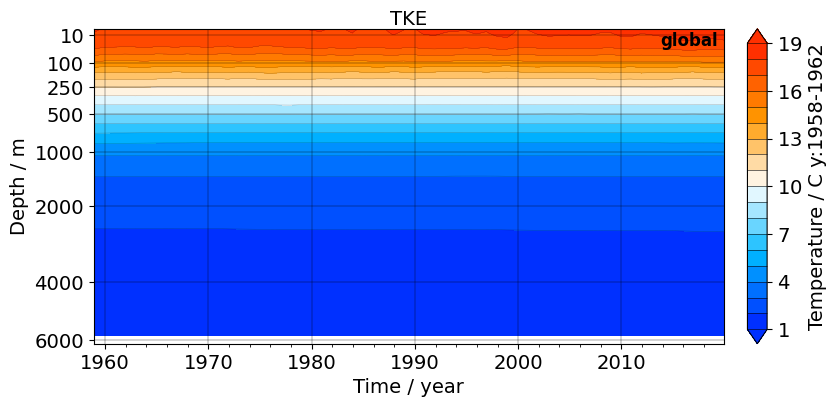

--> histo: cmin, cmax =  -1.3264405727386475 1.512319803237915
{'cstr': 'blue2red', 'cnum': 15, 'chist': True, 'ctresh': 0.995, 'cnlab': 8, 'cmin': np.float64(-1.33), 'cmax': np.float64(1.51), 'cref': np.float64(0.0), 'cmap': <matplotlib.colors.ListedColormap object at 0x7f5e9ed99040>, 'clevel': array([-1.4, -1.3, -1.2, -1.1, -1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4,
       -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,
        0.8,  0.9,  1. ,  1.1,  1.2,  1.3,  1.4,  1.5,  1.6]), 'clab': array([-1.2, -0.8, -0.4,  0. ,  0.4,  0.8,  1.2,  1.6])}
2.5 6125.0


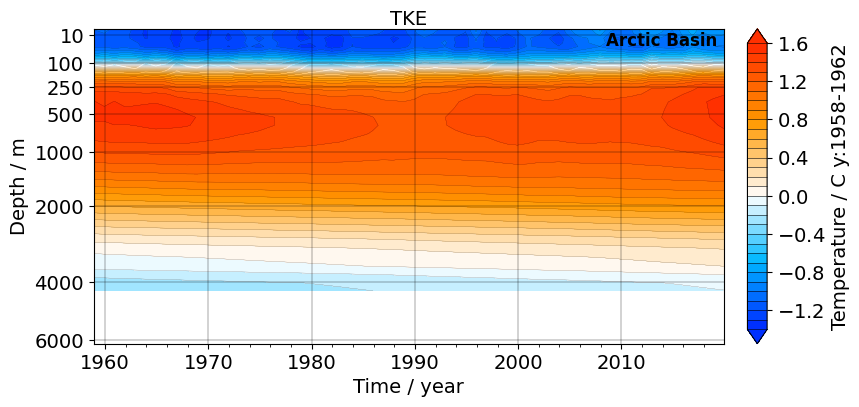

 --> elasped time to plot data: 0.01 min.


In [16]:
#___PLOT HOVM__________________________________________________________________________________________
ts = clock.time()
nbox, ndat = len(box), len(data_list)
if   ncol != None: 
    ncol0  = np.min([ncol,ndat])    
    nrow0  = np.ceil(ndat/ncol0).astype('int')
elif nrow != None: 
    nrow0  = np.min([nrow,ndat])    
    ncol0  = np.ceil(ndat/nrow0).astype('int')

for box_idx in range(nbox):
    svname = list(data_list[0][box_idx].data_vars)[0]
    slabel = data_list[0][box_idx][svname].attrs['str_lsave']
    sbox   = data_list[0][box_idx][svname].attrs['boxname'].replace(' ','_').lower()
    
    #__________________________________________________________________________________________________
    # do save filename path
    spath  = save_path
    sfpath = None
    if spath!=None: 
        sfpath=list()
        for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}_{:s}.{:s}'.format(svname, 'hovm', sbox ,slabel, sfmt)) )
    if save_fname!=None: sfpath = [save_fname] # --> needed for diagrun papermille functionality
   
    #__________________________________________________________________________________________________
    # do colorbar either single cbar or ref_cbar + anom_cbar
    if (ref_path != None) and do_reffig: cb_plt, cb_plt_single, cinfo0 = [1]+[2]*(nrow0*ncol0-1), False, [ref_cinfo.copy(), cinfo.copy()]
    else: cb_plt, cb_plt_single, cinfo0 = True, True, cinfo.copy() 
        
    #__________________________________________________________________________________________________    
    hfig, hax, hcb = tpv.plot_vslice(mesh, data_list, nrow=nrow0, ncol=ncol0, box_idx=box_idx, 
                                     cinfo=cinfo0, 
                                     do_plt=do_plt, plt_contb=plt_contb, plt_contf=plt_contf, plt_contr=plt_contr, plt_contl=plt_contl, do_enum=do_enum, 
                                     ax_opt=dict({'fig_sizefac':2.0, 'cb_plt':cb_plt, 'cb_plt_single':cb_plt_single, 'cb_pos':'vertical', 'cb_h':'auto',}), # 'fs_label':14, 'fs_ticks':14, 'ax_dt':1.0}),
                                     cbl_opt=dict(), cb_label=cb_label, cbtl_opt=dict(),
                                     do_save=sfpath, save_dpi=save_dpi )

print(' --> elasped time to plot data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))            

In [14]:
if do_papermill and do_parallel and client is not None: client.shutdown()